In [1]:
# dependencies
from rdkit import Chem
from rdkit.Chem import AllChem, ChemicalForceFields
from rdkit.Chem import rdmolfiles

import qml
from qml.representations import generate_fchl_acsf
from qml.kernels import get_atomic_local_kernel

import ase
from ase.visualize import view
from ase.optimize import LBFGS

import numpy as np

import ipywidgets

import matplotlib.pyplot as plt
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [57]:
c = qml.data.compound.Compound('../../dsgdb9nsd_050720.xyz')
#c = qml.data.compound.Compound('../../test/benzene.xyz')

In [42]:
def distance_sites(repA, repB, siteA, siteB, ZA, ZB):
    sigma = 1 # empirical
    sliceA = np.array([repA])[:,siteA:siteA+1,:]
    sliceB = np.array([repB])[:,siteB:siteB+1,:]
    
    inv_2sigma2 = -1.0 / (2 * sigma**2)
    inv_sigma2 = -1.0 / (sigma**2)
    
    q = get_atomic_local_kernel(sliceA, sliceB, np.array([ZA[siteA:siteA+1]]), np.array([ZB[siteB:siteB+1]]), sigma)[0][0]
    
    # revert transformation
    return np.log(-q/inv_sigma2)/inv_2sigma2

def distance_bn_nb(nuclear_charges, coordinates, idx_A, idx_B):
    A = nuclear_charges.copy()
    A[[idx_A, idx_B]] = (5, 7)
    B = nuclear_charges.copy()
    B[[idx_A, idx_B]] = (7, 5)
    repA, gradA = generate_fchl_acsf(A, coordinates, gradients=True, pad=len(nuclear_charges), elements=range(1, 10))
    repB, gradB = generate_fchl_acsf(B, coordinates, gradients=True, pad=len(nuclear_charges), elements=range(1, 10))
    
    delta = 0.01
    
    force = np.zeros((len(nuclear_charges), 3))
    basedist = distance_sites(repA, repB, idx_A, idx_B, A, B)
    for atomidx in range(len(nuclear_charges)):
        for dimension in range(3):
            repAprime = repA + delta * gradA[:, : , atomidx, dimension]
            repBprime = repB + delta * gradB[:, : , atomidx, dimension]
            graddist = distance_sites(repAprime, repBprime, idx_A, idx_B, A, B)
            dist = (graddist - basedist) / delta
            force[atomidx, dimension] = dist
    
    return basedist, force

%timeit distance_bn_nb(c.nuclear_charges, c.coordinates, 0, 11)

314 ms ± 59.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
import ase.calculators
class GapCalc(ase.calculators.calculator.Calculator):
    implemented_properties = 'energy forces'.split()
    
    def __init__(self, pdbfile):
        self._pdbfile = pdbfile
        self._nevals = 0
        self._damping = 1000
    
    def get_potential_energy(self, atoms=None, force_consistent=False):
        ds, gradds = distance_bn_nb(c.nuclear_charges, atoms.get_positions(), 4, 2)
        print (ds)
        
        # add UFF forces
        self._ffmol = Chem.MolFromPDBFile(self._pdbfile, removeHs=False)
        self._ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(self._ffmol)
        self._ff = ChemicalForceFields.MMFFGetMoleculeForceField(self._ffmol, self._ffprop)
        conf = self._ffmol.GetConformer(0)
        positions = atoms.get_positions()
        for atom in range(len(positions)):
            conf.SetAtomPosition(atom, positions[atom])
        uffE = self._ff.CalcEnergy()
        
        return uffE/self._damping + ds

    def get_forces(self, atoms=None):
        self._nevals += 1
        # QML forces
        ds, gradds = distance_bn_nb(c.nuclear_charges, atoms.get_positions(), 4, 2)
        
        # add UFF forces
        self._ffmol = Chem.MolFromPDBFile(self._pdbfile, removeHs=False)
        self._ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(self._ffmol)
        self._ff = ChemicalForceFields.MMFFGetMoleculeForceField(self._ffmol, self._ffprop)
        conf = self._ffmol.GetConformer(0)
        positions = atoms.get_positions()
        for atom in range(len(positions)):
            conf.SetAtomPosition(atom, positions[atom])
        uffgrad = np.array(self._ff.CalcGrad()).reshape(-1, 3)
        
        if self._nevals > 1000:
            return uffgrad * 0
        return - gradds - uffgrad/self._damping

In [44]:
def do_optimisation(c, idx_A, idx_B):
    stepsize = 0.001
    maxstep = 200
    
    hist_ds = []
    coordinates = c.coordinates.copy()
    while len(hist_ds) < maxstep:
        ds, gradds = distance_bn_nb(c.nuclear_charges, coordinates, idx_A, idx_B)
        hist_ds.append(ds)
        coordinates -= stepsize*gradds
        #print ('step')
    
    plt.plot(hist_ds)
    return coordinates
äcprime = do_optimisation(c, 2, 5)

KeyboardInterrupt: 

In [67]:
atm = ase.Atoms(numbers=c.nuclear_charges, positions=c.coordinates, calculator=GapCalc('../../dsgdb9nsd_050720.pdb'))
atmref = ase.Atoms(numbers=c.nuclear_charges, positions=c.coordinates, calculator=GapCalc('../../dsgdb9nsd_050720.pdb'))
dyn = LBFGS(atm, use_line_search=True,)
dyn.run(fmax=0.25)

0.20655157542102706
0.20655157542102706
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:19:51        0.300633*       0.5787
0.20655157542102706
0.1996669761033748
0.24227326686340464
0.19942748664164384
0.19942748664164384
LBFGS:    1 09:19:55        0.287033*       0.6406
0.19942748664164384
0.17918845139288378
0.14860944638108037
0.14860944638108037
LBFGS:    2 09:19:57        0.216197*       0.4963
0.14860944638108037
0.13117899543786152
0.13117899543786152
LBFGS:    3 09:19:59        0.199292*       0.4022
0.13117899543786152
0.11949344521901105
0.10880653719488204
0.11434840653022119
0.11434840653022119
LBFGS:    4 09:20:03        0.189415*       0.2827
0.11434840653022119
0.10443378109602137
0.10278367478440686
0.09979065653662764
0.09979065653662764
LBFGS:    5 09:20:06        0.180245*       0.2714
0.09979065653662764
0.09628275546679249
0.09525252409795087
0.09525252409795087
LBFGS:    6 09:20:09        0.172955

True

In [68]:
atm.get_positions() - c.coordinates
#distance_bn_nb(c.nuclear_charges, atm.get_positions(), 4, 2)

array([[-0.03189321,  0.13427755,  0.0167754 ],
       [-0.0629335 , -0.05850615, -0.01872664],
       [ 0.01969069, -0.05971492,  0.01913841],
       [-0.005444  , -0.05217528, -0.02163958],
       [ 0.04621834, -0.10826374, -0.02907813],
       [ 0.01904115, -0.04848301,  0.00057136],
       [-0.01314061, -0.05145481, -0.02981585],
       [-0.01775651, -0.08523781, -0.06933683],
       [-0.00822302,  0.08600102,  0.07717181],
       [ 0.01415637, -0.125341  , -0.01009263],
       [-0.04061174, -0.03715592, -0.02833843],
       [ 0.04489624,  0.0421555 , -0.01921508],
       [ 0.02366844, -0.08073166, -0.04307222],
       [ 0.07050819,  0.06934328, -0.04292367],
       [-0.09416186,  0.09133925, -0.06293956],
       [-0.15441549,  0.01037028, -0.00768028],
       [-0.02445943,  0.0080128 ,  0.01432407]])

In [70]:
view(atm, viewer='x3d')
#import nglview
#nglview.show_ase(atm)

In [52]:
m = Chem.MolFromPDBFile('../../dsgdb9nsd_050720.pdb', removeHs=False)
#m = Chem.MolFromPDBFile('../../benzene.pdb', removeHs=False)

In [63]:
m = Chem.MolFromPDBFile('../../dsgdb9nsd_050720.pdb', removeHs=False)
ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(m)
forcefield = ChemicalForceFields.MMFFGetMoleculeForceField(m, ffprop)

In [81]:
grad = np.array(forcefield.CalcGrad()).reshape(-1, 3)
grad

array([[-9.09209325e+01,  1.68600116e+01,  3.56993632e+00],
       [ 2.10866099e+01,  8.28853018e+01,  1.62830173e+01],
       [ 6.68977451e+00, -6.71020122e+00, -2.11993077e+01],
       [ 6.52415747e+01, -2.01186408e+01, -7.07765738e+01],
       [ 8.42463436e-01, -1.34776650e+01, -1.39986603e+01],
       [-2.93208775e+00, -2.78113109e+01, -1.50210958e+01],
       [-1.53506616e+01, -1.66590871e+01, -2.09248642e+00],
       [-9.90759197e+00,  7.93036100e+01,  7.17728799e+01],
       [-2.22757639e+01,  2.95503756e+01,  3.04735262e+01],
       [ 1.03361490e+02,  4.83480373e+01,  2.26540782e+00],
       [ 6.40050807e+01,  5.02526657e+01, -2.29172237e+01],
       [ 2.10688236e+01, -1.96609884e+01,  8.34972811e+01],
       [ 4.50862235e-03, -6.81456383e+01, -5.11523213e+01],
       [ 2.69393770e-01, -3.88443034e+01,  7.92615583e+01],
       [-1.26675065e+01,  1.51146422e+01, -8.40792931e+01],
       [-6.92791941e+01, -4.58520786e+01,  1.84311840e+01],
       [-5.92359807e+01, -6.50347302e+01

In [68]:
scales = []
norms = []
es = []
for scale in np.linspace(0.5, 1.2, 10):
    m = Chem.MolFromPDBFile('../../dsgdb9nsd_050720.pdb', removeHs=False)
    ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(m)
    forcefield = ChemicalForceFields.MMFFGetMoleculeForceField(m, ffprop)
    conf = m.GetConformer(0)
    for atom in range(c.natoms):
        conf.SetAtomPosition(atom, c.coordinates[atom]*scale)
    grad = np.array(forcefield.CalcGrad()).reshape(-1, 3)
    es.append(forcefield.CalcEnergy())
    norms.append(np.linalg.norm(grad))
    scales.append(scale)

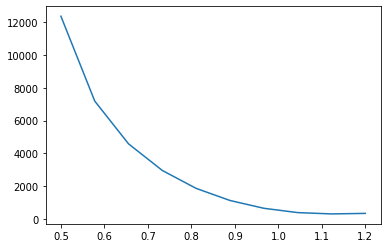

In [72]:
plt.plot(scales, norms)

In [34]:
def ase_atoms_to_pyscf(ase_atoms):
    return [ [ase_atoms.get_chemical_symbols()[i], ase_atoms.get_positions()[i]] for i in range(len(ase_atoms.get_positions()))]

def get_hf_diff(atoms, A, B):
    energies = []
    for iA, iB in ((A, B), (B, A)):
        atoms.numbers[iA] = 7
        atoms.numbers[iB] = 5
        pymol = pyscf.gto.Mole()
        pymol.atom = ase_atoms_to_pyscf(atoms)
        pymol.basis = '6-31G'
        pymol.verbose = 0
        pymol.build()
        energies.append(pyscf.scf.RHF(pymol).kernel())
    return energies[1] - energies[0]
    

In [36]:
get_hf_diff(atm, 4, 2)

0.0144606513113672

## Analysis

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('merged.log', sep=' ', names='step drep dener site1 site2 molid'.split())

(-5, 5)

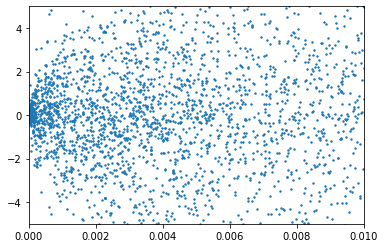

In [48]:
plt.scatter(df.drep, df.dener*630, s=2)
plt.xlim(0, 0.01)
plt.ylim(-5, 5)

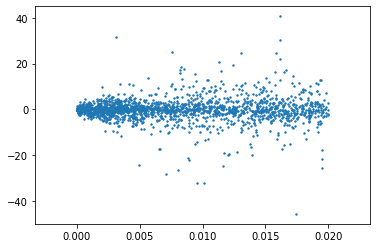

In [51]:
s = df.query('drep < 0.02 & step == "init"')
plt.scatter(s.drep, s.dener*630, s=2)

In [52]:
s.sort_values('drep')

,step,drep,dener,site1,site2,molid
87343,init,-0.000000e+00,-1.468834e-10,5,7,17844
87307,init,-0.000000e+00,1.722356e-10,1,3,17844
63026,init,3.996803e-15,-4.235289e-09,4,5,41042
63440,init,7.327472e-15,-4.230060e-09,1,4,23715
5244,init,9.769963e-15,1.607532e-10,2,7,8565
...,...,...,...,...,...,...
24933,init,1.984346e-02,1.155531e-02,1,8,37831
103928,init,1.994027e-02,-5.446539e-04,4,5,14333
11648,init,1.995177e-02,-4.003199e-03,1,4,47305
13863,init,1.997820e-02,-3.361135e-03,2,8,127292


In [55]:
# maybe FCHL is too restrictive on distances, add CM 
basepath = '/mnt/c/Users/guido/data/qm9/'
fns = pd.read_csv(basepath + 'index', names=['fn']).fn.values


In [60]:
def get_site_similarity(c):
    atoms = np.where(c.nuclear_charges == 6)[0]
    a = qml.representations.generate_coulomb_matrix(c.nuclear_charges, c.coordinates, size=c.natoms, sorting='unsorted')
    s = np.zeros((c.natoms, c.natoms))
    s[np.tril_indices(c.natoms)] = a
    d = np.diag(s)
    s += s.T
    s[np.diag_indices(c.natoms)] = d
    sorted_elements = [np.sort(_) for _ in s[atoms]]
    ret = []
    for i in range(len(atoms)):
            for j in range(i+1, len(atoms)):
                dist = np.linalg.norm(sorted_elements[i] - sorted_elements[j])
                ret.append([atoms[i], atoms[j], dist])
    return ret
get_site_similarity(c)

[[1, 2, 11.123569681203662],
 [1, 4, 12.89233078860838],
 [1, 5, 10.694346132285483],
 [1, 7, 14.169376876514287],
 [2, 4, 4.1594491965910505],
 [2, 5, 7.097405110091855],
 [2, 7, 10.290123610350832],
 [4, 5, 7.700039344164439],
 [4, 7, 10.145304503223088],
 [5, 7, 15.103001476400632]]

In [77]:
import functools
@functools.lru_cache(maxsize=3000)
def get_similarities(molid):
    fn = [_ for _ in fns if '%06d' % molid in _][0]
    c = qml.data.compound.Compound(basepath + fn)
    return get_site_similarity(c)
    
def get_cm_dist(row):
    try:
        sim = get_similarities(row['molid'])
    except:
        return None
    for item in sim:
        if item[0] == row['site1'] and item[1] == row['site2']:
            return item[2]

In [78]:
s = df.query('step=="init"').copy()
cmdist = s.apply(get_cm_dist, axis=1)

In [79]:
s['cmdist'] = cmdist

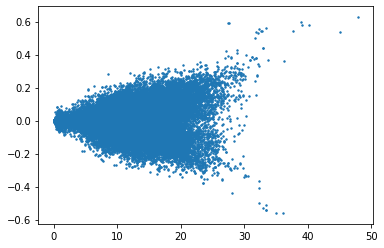

In [82]:
plt.scatter(s.cmdist, s.dener, s=2)